#### Import libraries

In [110]:
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx

#### Read station and population files

In [140]:
# Read population shapefile
fp = "population_data/population.shp"
population = gpd.read_file(fp)

# Read stations shapefile
fp = "stations_data/stations.shp"
stations = gpd.read_file(fp)

stations.head()

,Name,Opened,Type,geometry
0,Espoo,1903,Train,POINT (2744784.758 8445625.162)
1,Helsinki Center Station,1862,Train/Metro,POINT (2776450.701 8437894.974)
2,Hiekkaharju,1931,Train,POINT (2788487.121 8467534.963)
3,Huopalahti,1910,Train,POINT (2771325.997 8448441.335)
4,Ilmala,1967,Train,POINT (2774229.432 8446094.524)


#### Create buffer around stations with radius of 500 meters

In [145]:
# Copy dataframe stations
buffer = stations

# Rename buffer geometry as coordinate
buffer["coordinate"] = buffer["geometry"]

# Change crs to metric system to create buffer around stations with radius 500 meters
buffer = stations.to_crs(epsg=3395)

# Create buffer with radius 1000 meters (area where is less than 500 meters to station)
buffer["geometry"] = buffer.buffer(1000, cap_style=1)

# Change crs back to crs 3857
buffer = buffer.to_crs(epsg=3857)

buffer

,Name,Opened,Type,geometry,coordinate
0,Espoo,1903,Train,"POLYGON ((2745784.758 8445625.162, 2745779.943...",POINT (2744784.758 8445625.162)
1,Helsinki Center Station,1862,Train/Metro,"POLYGON ((2777450.701 8437894.974, 2777445.885...",POINT (2776450.701 8437894.974)
2,Hiekkaharju,1931,Train,"POLYGON ((2789487.121 8467534.963, 2789482.305...",POINT (2788487.121 8467534.963)
3,Huopalahti,1910,Train,"POLYGON ((2772325.997 8448441.335, 2772321.181...",POINT (2771325.997 8448441.335)
4,Ilmala,1967,Train,"POLYGON ((2775229.432 8446094.524, 2775224.616...",POINT (2774229.432 8446094.524)
...,...,...,...,...,...
58,Siilitie,1982,Metro,"POLYGON ((2788919.503 8445637.484, 2788914.687...",POINT (2787919.503 8445637.484)
59,Sörnäinen,1984,Metro,"POLYGON ((2779633.119 8441676.764, 2779628.304...",POINT (2778633.119 8441676.764)
60,Tapiola,2017,Metro,"POLYGON ((2762330.619 8438838.784, 2762325.804...",POINT (2761330.619 8438838.784)
61,Urheilupuisto,2017,Metro,"POLYGON ((2759488.188 8438689.047, 2759483.372...",POINT (2758488.188 8438689.047)


#### Plot buffer around stations to make sure it looks correct

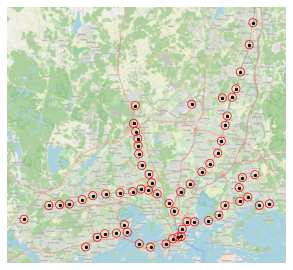

In [113]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(5,5))

# Plot rails
stations.plot(ax=ax, color="black", markersize=5)

# Plot stations
buffer.plot(ax=ax, facecolor="none", edgecolor='red', lw=0.7)

# remove the axis
ax.axis("off")

# Add basemap with `OMS_A` style
ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)

### Calculate population in buffers

In [155]:
# Change population crs to match crs in buffer dataframe
population = population.to_crs(epsg=3857)

# Calculate population centroid
population["geometry"] = population.centroid

# Find all the population centroids inside the stations buffers
stations_population = gpd.sjoin(buffer, population, op='contains', how='inner')

# Group data by Name and calculate population sum on each station
stations_population = pd.DataFrame(stations_population)
stations_population = stations_population.drop(columns=['geometry', 'coordinate', 'Type', "Opened"])
stations_population = stations_population.groupby(stations_population.index).sum()

# Merge stations_population_tmp with stations
stations_population = pd.merge(stations, stations_population, left_index=True, right_index=True)

# Drop column index_right, which is old index od population dataframe
stations_population = stations_population.drop(columns=["index_right"])

# Print first rows
stations_population.head(3)

,Name,Opened,Type,geometry,coordinate,pop1997,pop1998,pop1999,pop2000,pop2001,...,pop2010,pop2011,pop2012,pop2013,pop2014,pop2015,pop2016,pop2017,pop2018,pop2019
0,Espoo,1903,Train,POINT (2744784.758 8445625.162),POINT (2744784.758 8445625.162),3604.0,3642.0,2195.0,2142.0,3484.0,...,3537.0,3637.0,4003.0,3952.0,4229.0,4256.0,4356.0,4206.0,4400.0,4173.0
1,Helsinki Center Station,1862,Train/Metro,POINT (2776450.701 8437894.974),POINT (2776450.701 8437894.974),546.0,518.0,711.0,713.0,497.0,...,493.0,479.0,523.0,533.0,562.0,556.0,550.0,545.0,581.0,594.0
2,Hiekkaharju,1931,Train,POINT (2788487.121 8467534.963),POINT (2788487.121 8467534.963),2513.0,2616.0,2808.0,2768.0,2635.0,...,2699.0,2683.0,2701.0,2702.0,2672.0,2660.0,2666.0,2685.0,2663.0,2668.0


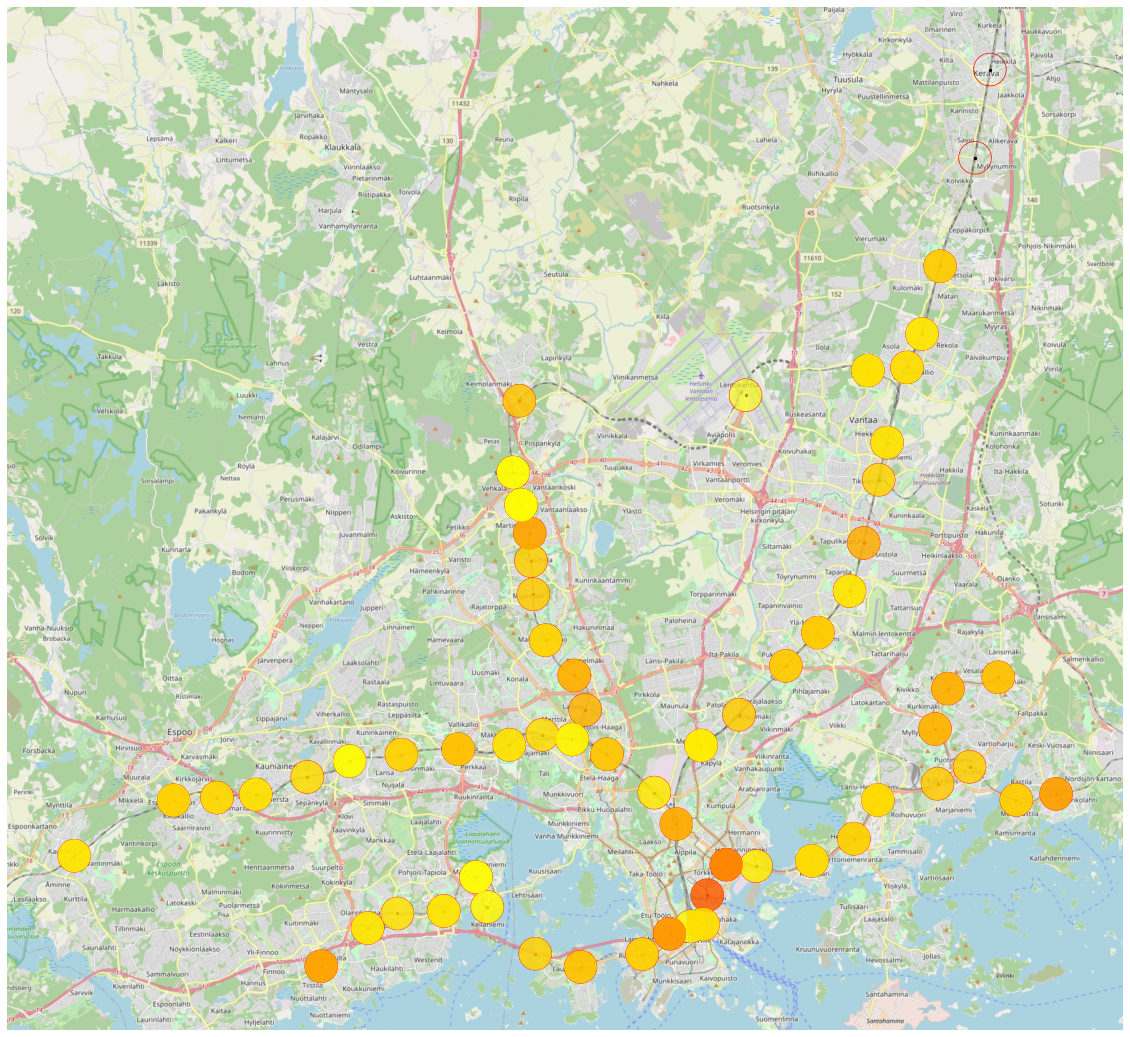

In [152]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(20,20))

# Plot rails
stations.plot(ax=ax, color="black", markersize=5)

# Plot stations
buffer.plot(ax=ax, facecolor="none", edgecolor='red', lw=0.7)

# Plot buffer population grid
stations_population.plot(ax=ax, column='pop2019', cmap='autumn_r', linewidth=0.5, alpha=0.6)

# remove the axis
ax.axis("off")

# Add basemap with `OMS_A` style
ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)

